# Unseen Semantic Diversity

In [1]:
from pathlib import Path

plays = {}

root = Path("../data/shakespeare_txt")
for path in root.iterdir():
    if path.suffix == ".txt":
        title = path.name[:path.name.index("_")]
        with path.open() as f:
            forms, lemmas = zip(*[line.rstrip('\n').split('\t') for line in f])
            plays[title] = {"forms": forms, "lemma": lemmas}

## Estimating the Vocabulary Size of Shakespeare's Lexicon

In [2]:
import copia.utils

counts = copia.utils.to_abundance(
    [w for play in plays.values() for w in play["forms"]]
)

observed_lexical_diversity = len(counts)

print(f"Observed lexical diversity: {round(observed_lexical_diversity)}")

Observed lexical diversity: 31761


The observed lexical diversity is slightly higher than the number given by Efron and Thisted (1976): 

$$
\sum^{\infty}_{x = 1} n_x = 31534
$$

But the difference in negligible. How many words did Shakespeare actually know? We use the unseen species estimator Chao1 (Chao 1984) to estimate Shakespeare's true vocabulary size:

In [3]:
import copia.estimators

estimated_lexical_diversity = copia.estimators.chao1(counts)
print(f"Estimated lexical diversity: {round(estimated_lexical_diversity)}")

Estimated lexical diversity: 55285


This number is close to the estimation by Efron and Thisted (1976) who calculate that the complete vocabulary size of Shakespeare was around 57704.

We can do the same thing for the individual plays. When applied to plays, the question we're asking is how large the vocabulary of a play would if we increase its length to infinity. 

In [4]:
import pandas as pd 

estimates = []

for play in plays:
    counts = copia.utils.to_abundance([w for w in plays[play]["forms"]])
    observed_lexical_diversity = len(counts)
    estimated_lexical_diversity = copia.estimators.chao1(counts)
    estimates.append({"play": play, 
                      "obs": observed_lexical_diversity, 
                      "est": estimated_lexical_diversity})
estimates = pd.DataFrame(estimates)
estimates["coverage"] = estimates["obs"] / estimates["est"]
estimates.sort_values("coverage")

,play,obs,est,coverage
19,antony-and-cleopatra,4405,10453.165176,0.421403
12,king-lear,4672,11029.200114,0.423603
5,macbeth,3694,8579.005524,0.430586
20,troilus-and-cressida,4708,10719.541123,0.439198
21,twelfth-night,3389,7694.191321,0.440462
26,hamlet,5157,11684.907005,0.441339
22,henry-iv-part-2,4483,9989.904893,0.448753
6,alls-well-that-ends-well,3862,8597.776736,0.449186
9,the-merry-wives-of-windsor,3590,7958.490507,0.451091
36,measure-for-measure,3699,8178.341008,0.452292


Not sure if it means anything, but it's interesting to see so many of the really famous plays so high up in the ranking. Those high in the ranking have a remarkably high lexical diversity given the number of observed words. 

## Estimating the Semantic Diversity of Shakespeare's Lexicon

In [5]:
import numpy as np

data = np.load("../data/shakespeare.embs.forms.npz")
keys, vecs = data["keys"], data["vecs"]

In [6]:
import collections
from sklearn.metrics import pairwise

dists = pairwise.cosine_distances(vecs)
counts = collections.Counter(w for play in plays.values() for w in play["forms"])
counts = np.array([counts[w] for w in keys])

In [7]:
FAD = copia.estimators._compute_fad(dists, counts)
FAD["max"] = dists.shape[0] * (dists.shape[0] - 1)

In [17]:
FAD

{'obs': 142168352,
 'F0+': 79275236,
 'F+0': 79275173,
 'F00': 43939004,
 'FAD': 344657765,
 'CI_lower': 344554297.2847604,
 'CI_upper': 344761285.7673435,
 'max': 264468906}

In [14]:
import math

def oom(x):
    return math.floor(math.log10(x))

oom(FAD["FAD"])

8

In [22]:
FAD["obs"] / FAD["max"]

0.537561689766282

In [25]:
fad_estimates = []

for play in plays:
    counts = collections.Counter(w for w in plays[play]["forms"])
    counts = np.array([counts[w] for w in keys])
    fad = copia.estimators._compute_fad(dists, counts)
    fad["play"] = play
    fad_estimates.append(fad)

fad_estimates = pd.DataFrame(fad_estimates)
fad_estimates["coverage"] = fad_estimates["obs"] / fad_estimates["FAD"]

In [26]:
fad_estimates.sort_values("FAD")

,obs,F0+,F+0,F00,FAD,CI_lower,CI_upper,play,coverage
7,2472592,1757734,1757735,1244295,7232356,7.215930e+06,7.248838e+06,julius-caesar,0.341879
28,2199379,1835329,1835329,1525606,7395644,7.376191e+06,7.415170e+06,the-comedy-of-errors,0.297388
3,2470841,1944533,1944534,1525635,7885542,7.866593e+06,7.904558e+06,the-two-gentlemen-of-verona,0.313338
2,3022068,2160525,2160527,1540631,8883752,8.866419e+06,8.901136e+06,a-midsummer-nights-dream,0.340179
23,3127520,2230486,2230486,1582530,9171022,9.153626e+06,9.188469e+06,pericles,0.341022
15,3019396,2441502,2441503,1967852,9870253,9.848221e+06,9.892355e+06,much-ado-about-nothing,0.305909
10,3308983,2479497,2479496,1849870,10117845,1.009785e+07,1.013790e+07,the-merchant-of-venice,0.327044
24,3095312,2583289,2583289,2147594,10409483,1.038633e+07,1.043271e+07,timon-of-athens,0.297355
4,3454299,2574464,2574461,1913754,10516978,1.049686e+07,1.053715e+07,as-you-like-it,0.328450
27,3398126,2655077,2655077,2066081,10774361,1.075249e+07,1.079629e+07,the-taming-of-the-shrew,0.315390


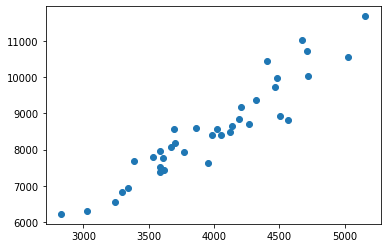

In [11]:
import matplotlib.pyplot as plt

plt.scatter(estimates["obs"], estimates["est"])

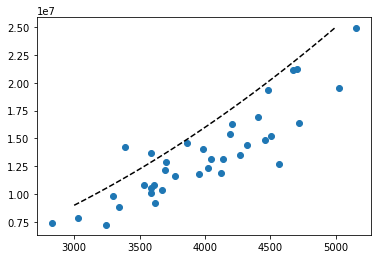

In [40]:
est = pd.merge(estimates, fad_estimates, on="play")

fig, ax = plt.subplots()
ax.scatter(est["obs_x"], est["FAD"])
x = np.linspace(3000, 5000)
ax.plot(x, x * (x - 1), 'k--')

In [13]:
est

,play,obs_x,est,coverage_x,obs_y,F0+,F+0,F00,FAD,CI_lower,CI_upper,coverage_y
0,henry-vi-part-2,4505,8941.986767,0.503803,5098648,3711478,3711480,2692680,15214285,1.519096e+07,1.523767e+07,0.335122
1,coriolanus,4463,9731.790077,0.458600,4383908,3682740,3682740,3084074,14833462,1.480520e+07,1.486180e+07,0.295542
2,a-midsummer-nights-dream,3345,6928.592907,0.482782,3022068,2160525,2160527,1540631,8883752,8.866419e+06,8.901136e+06,0.340179
3,the-two-gentlemen-of-verona,3027,6309.787487,0.479731,2470841,1944533,1944534,1525635,7885542,7.866593e+06,7.904558e+06,0.313338
4,as-you-like-it,3587,7370.616163,0.486662,3454299,2574464,2574461,1913754,10516978,1.049686e+07,1.053715e+07,0.328450
5,macbeth,3694,8579.005524,0.430586,3247382,3044778,3044781,2848328,12185270,1.215680e+07,1.221383e+07,0.266501
6,alls-well-that-ends-well,3862,8597.776736,0.449186,3842578,3659195,3659197,3469958,14630929,1.459729e+07,1.466467e+07,0.262634
7,julius-caesar,3245,6551.581368,0.495300,2472592,1757734,1757735,1244295,7232356,7.215930e+06,7.248838e+06,0.341879
8,henry-viii,4020,8567.941191,0.469191,3817265,3060975,3060975,2446256,12385471,1.236083e+07,1.241019e+07,0.308205
9,the-merry-wives-of-windsor,3590,7958.490507,0.451091,3529823,3427874,3427875,3316302,13701874,1.366936e+07,1.373449e+07,0.257616
